Dynamic Initial Margin (%) for SET50 (Last 10 days):
Date
2018-01-23    2.067263
2018-01-24    2.069497
2018-01-25    2.056905
2018-01-26    2.434772
2018-01-29    2.442354
2018-01-30    2.438815
2018-01-31    2.455931
2018-02-01    2.437442
2018-02-02    2.432415
2018-02-05    2.419819
dtype: float64


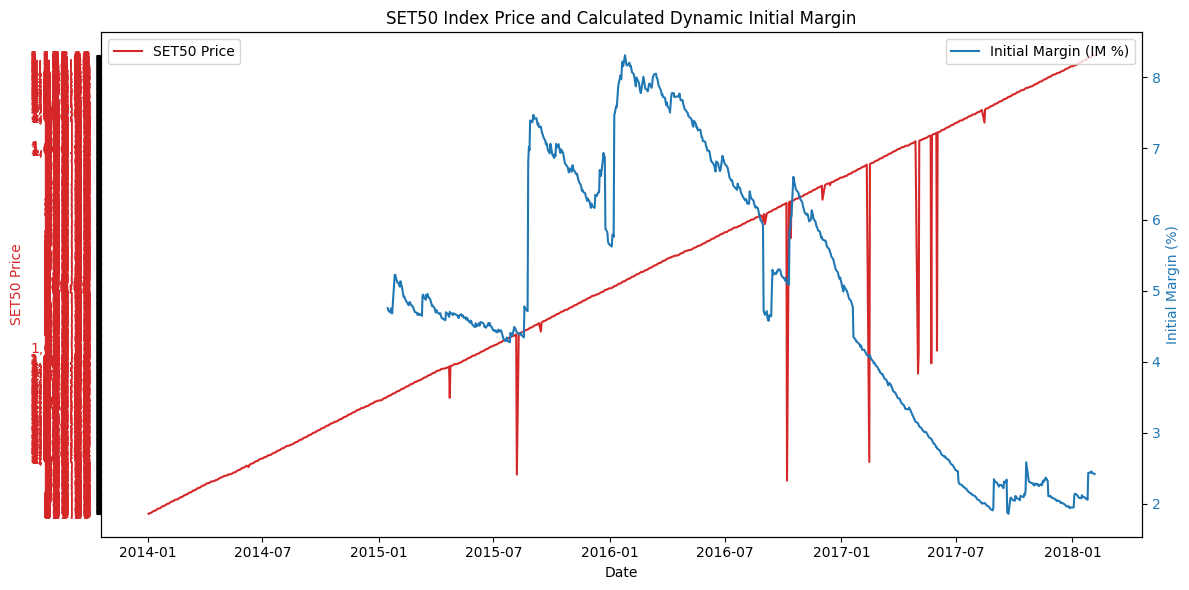

In [4]:
import numpy as np
import pandas as pd
import io # Needed to read the file content as a string

def calculate_log_returns(prices):
    """Calculates daily log returns from a series of prices."""
    # Ensure prices are numeric after cleaning
    prices_numeric = pd.to_numeric(prices.str.replace(',', '', regex=False), errors='coerce')
    return np.log(prices_numeric / prices_numeric.shift(1)).dropna()

def ewma_volatility(returns, lambda_decay):
    """Calculates EWMA volatility."""
    variances = np.zeros_like(returns)
    if len(returns) > 0:
        # Initialize with the variance of the first year (or available data if less)
        initial_window_size = min(len(returns), 252) # Use up to 1 year for initial variance
        initial_variance = np.var(returns[:initial_window_size])
        if initial_variance == 0 or np.isnan(initial_variance):
             initial_variance = returns[0]**2 if not np.isnan(returns[0]) and returns[0] != 0 else 0.000001 # Fallback if variance is zero/NaN

        variances[0] = initial_variance

        for t in range(1, len(returns)):
            # Ensure returns[t-1] is not NaN before squaring
            squared_return = returns[t-1]**2 if not np.isnan(returns[t-1]) else 0
            variances[t] = lambda_decay * variances[t-1] + (1 - lambda_decay) * squared_return
    return np.sqrt(variances)

def fhs_var(daily_returns,
            current_volatility,
            historical_volatilities,
            historical_returns_for_simulation,
            confidence_level,
            mpor_days):
    """
    Calculates Filtered Historical Simulation (FHS) VaR for a given MPOR.
    """
    if len(historical_returns_for_simulation) == 0 or len(historical_volatilities) == 0 or current_volatility == 0:
        return np.nan

    # Remove NaN values that might occur due to volatility calculation issues
    valid_indices = ~np.isnan(historical_returns_for_simulation) & ~np.isnan(historical_volatilities) & (historical_volatilities > 1e-9) # Avoid division by zero
    
    if np.sum(valid_indices) == 0: # Check if any valid data points remain
        return np.nan
        
    historical_returns_sim_window_clean = historical_returns_for_simulation[valid_indices]
    historical_vol_sim_window_clean = historical_volatilities[valid_indices]

    # Standardize historical returns
    standardized_returns = historical_returns_sim_window_clean / historical_vol_sim_window_clean

    # Rescale standardized returns with current volatility
    rescaled_returns = standardized_returns * current_volatility

    # Calculate 1-day VaR
    var_1_day = np.percentile(rescaled_returns, (1 - confidence_level) * 100)

    # Adjust for MPOR using the square root of time rule
    var_mpor_days = -var_1_day * np.sqrt(mpor_days)

    return var_mpor_days

def calculate_dynamic_initial_margin(price_series,
                                     lookback_period_vol=252, # For EWMA initialization/overall view
                                     lookback_period_fhs=252, # For FHS simulation window
                                     lambda_decay=0.985,      # Decay factor for EWMA
                                     confidence_level=0.99,   # Confidence level for VaR
                                     mpor_days=5):
    """
    Calculates dynamic initial margin for a series of prices.

    Args:
        price_series (pd.Series): A pandas Series of historical prices of the index.
        lookback_period_vol (int): Lookback period for initial volatility calculation.
        lookback_period_fhs (int): Lookback period for historical simulation in FHS.
        lambda_decay (float): Decay factor for EWMA volatility.
        confidence_level (float): Confidence level for VaR (e.g., 0.99 for 99%).
        mpor_days (int): Margin Period of Risk in days.

    Returns:
        pd.Series: A pandas Series containing the dynamic initial margin (as percentage).
    """
    if not isinstance(price_series, pd.Series):
        raise ValueError("price_series must be a pandas Series.")
    if price_series.isnull().any():
        print("Warning: price_series contains NaN values. Attempting to proceed by dropping NaNs in return calculation.")
        # Note: NaNs might still cause issues later if they create gaps. Consider filling or handling them more robustly if needed.
        
    # Calculate log returns, handling potential NaNs from price data
    daily_log_returns = calculate_log_returns(price_series)
    daily_log_returns = daily_log_returns.dropna() # Drop NaNs resulting from calculation or original data

    if daily_log_returns.empty:
         raise ValueError("No valid log returns could be calculated from the price series.")
        
    if len(daily_log_returns) < max(lookback_period_vol, lookback_period_fhs):
        raise ValueError(f"Not enough valid return data after processing. Need at least {max(lookback_period_vol, lookback_period_fhs)} data points for lookback periods.")

    all_volatilities = ewma_volatility(daily_log_returns.values, lambda_decay)
    
    # Convert volatilities to a pandas Series with the same index as returns
    all_volatilities_series = pd.Series(all_volatilities, index=daily_log_returns.index)

    initial_margins = []
    dates = [] # To store corresponding dates for margins

    # Start calculation after enough data is available for the FHS lookback period
    start_index_for_fhs = lookback_period_fhs

    for t in range(start_index_for_fhs, len(daily_log_returns)):
        # Current volatility for day T+1 (forecast made at T using data up to T)
        current_sigma_t_plus_1 = all_volatilities_series.iloc[t]

        # Historical data window ends at T (index t-1 in zero-based indexing)
        historical_returns_sim_window = daily_log_returns.iloc[t - lookback_period_fhs : t]
        historical_vol_sim_window = all_volatilities_series.iloc[t - lookback_period_fhs : t]

        im_value = fhs_var(daily_returns=daily_log_returns.iloc[:t].values,
                           current_volatility=current_sigma_t_plus_1,
                           historical_volatilities=historical_vol_sim_window.values,
                           historical_returns_for_simulation=historical_returns_sim_window.values,
                           confidence_level=confidence_level,
                           mpor_days=mpor_days)

        initial_margins.append(im_value * 100) # Store as percentage
        dates.append(daily_log_returns.index[t]) # Margin for day T+1, calculated based on data up to T

    return pd.Series(initial_margins, index=pd.Index(dates, name="Date"))

# --- Code to read the uploaded file and run the calculation ---

# Get the content of the uploaded file
filename = 'SET50_2014-2025.csv' 
# Read the CSV data using pandas
# Use io.StringIO to treat the string content as a file
try:
    df = pd.read_csv(filename)
    df = df[-1000:]

    # --- Data Cleaning and Preparation ---
    # 1. Parse 'Date' column to datetime objects
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y') # Adjust format if needed

    # 2. Sort data by date (oldest first) as time series calculations require it
    df = df.sort_values(by='Date').reset_index(drop=True)

    # 3. Set 'Date' as index
    df.set_index('Date', inplace=True)

    # 4. Select the 'Price' column (ensure it's cleaned for numeric conversion later)
    set50_prices = df['Price']
    # --- End Data Cleaning ---

    # --- Calculation ---
    # Calculate the dynamic initial margin
    dynamic_im_set50 = calculate_dynamic_initial_margin(
        price_series=set50_prices,
        lookback_period_fhs=252,  # 1 year lookback for FHS simulation
        lambda_decay=0.985,       # Decay factor from paper example
        confidence_level=0.99,    # Confidence level from paper example
        mpor_days=5               # Your specified MPOR
    )

    # Display the last 10 calculated initial margin values
    print("Dynamic Initial Margin (%) for SET50 (Last 10 days):")
    print(dynamic_im_set50.tail(10))

    # --- Plotting (Optional) ---
    # You can uncomment the following lines to plot the results
    import matplotlib.pyplot as plt
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('SET50 Price', color=color)
    ax1.plot(set50_prices, color=color, label='SET50 Price')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Initial Margin (%)', color=color)
    ax2.plot(dynamic_im_set50, color=color, label='Initial Margin (IM %)')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')
    
    plt.title('SET50 Index Price and Calculated Dynamic Initial Margin')
    fig.tight_layout() # otherwise the right y-label is slightly clipped
    plt.show()
    # --- End Plotting ---

except FileNotFoundError:
    print("Error: The file 'SET 50 Historical Data (4).csv' was not found.")
except KeyError as e:
    print(f"Error: Column '{e}' not found in the CSV file. Please check column names.")
except ValueError as e:
    print(f"Error during calculation: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Total number of returns: 2760
Calculating 1-year HS VaR...
1-year HS VaR calculated. Length: 2509
Calculating 5-year HS VaR...
5-year HS VaR calculated. Length: 1501
Calculating 10-year HS VaR...
10-year HS VaR calculated. Length: 241
Plotting data from 2024-05-15 00:00:00 to 2025-05-06 00:00:00


/var/folders/rc/w7r40l35143bxwkzfxdygctc0000gn/T/ipykernel_49445/1379999801.py:124: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  markerline, stemlines, baseline = ax.stem(losses.loc[common_index].index,


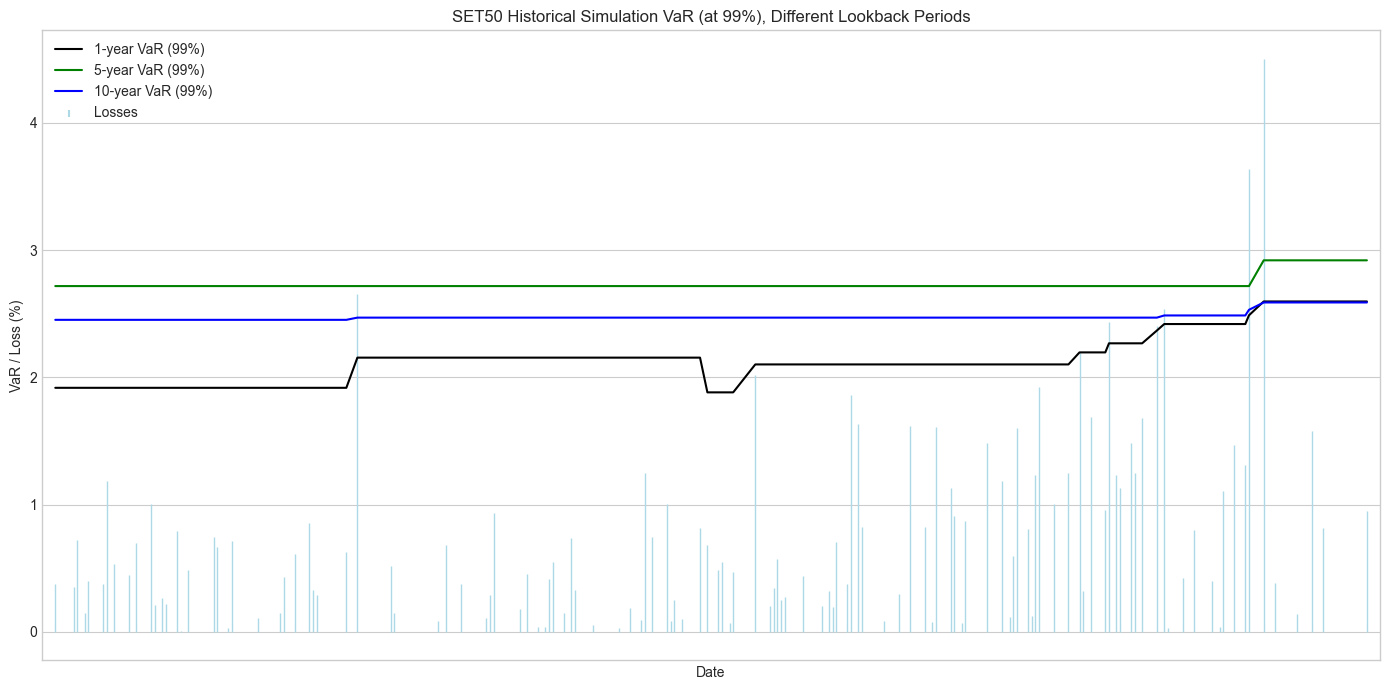

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def calculate_log_returns(prices):
    """Calculates daily log returns from a series of prices."""
    prices_numeric = pd.to_numeric(prices.str.replace(',', '', regex=False), errors='coerce')
    return np.log(prices_numeric / prices_numeric.shift(1)).dropna()

def calculate_hs_var(returns_window, confidence_level=0.99):
    """
    Calculates 1-day Historical Simulation VaR.
    """
    if returns_window.empty or returns_window.isnull().all():
        return np.nan
    # VaR for losses is the (1 - confidence_level) percentile
    var_value = np.percentile(returns_window.dropna(), (1 - confidence_level) * 100)
    # Return VaR as a positive value representing potential loss
    return -var_value

# --- Code to read the file and run the calculation ---
filename = 'SET50_2014-2025.csv' # <-- ตรวจสอบชื่อไฟล์และ path ให้ถูกต้อง
try:
    # อ่านไฟล์ CSV
    df = pd.read_csv(filename)

    # --- Data Cleaning and Preparation ---
    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    except ValueError:
        try:
            df['Date'] = pd.to_datetime(df['Date'])
        except Exception as date_err:
            print(f"Error parsing Date column: {date_err}")
            raise date_err

    df = df.sort_values(by='Date').reset_index(drop=True)
    df.set_index('Date', inplace=True)

    # Select Price column
    if 'Price' in df.columns:
        price_col_name = 'Price'
    else:
        potential_price_cols = ['Close', 'Last', 'Adj Close']
        price_col_name = next((col for col in potential_price_cols if col in df.columns), None)
        if price_col_name is None:
             raise KeyError("Could not find a suitable price column.")
        print(f"Using column '{price_col_name}' for price data.")

    set50_prices = df[price_col_name]
    daily_log_returns = calculate_log_returns(set50_prices).dropna()
    # --- End Data Cleaning ---

    # --- HS VaR Calculation (1, 5, 10 year lookback) ---
    confidence = 0.99
    trading_days_per_year = 252 # Assumption for trading days per year

    lookback_1y = trading_days_per_year * 1
    lookback_5y = trading_days_per_year * 5  # Changed from 12y
    lookback_10y = trading_days_per_year * 10

    # Calculate VaR using rolling windows
    start_1y = lookback_1y
    start_5y = lookback_5y  # Changed from start_12y
    start_10y = lookback_10y

    hs_var_1y = pd.Series(dtype=float)
    hs_var_5y = pd.Series(dtype=float) # Changed from hs_var_12y
    hs_var_10y = pd.Series(dtype=float)

    print(f"Total number of returns: {len(daily_log_returns)}")

    if len(daily_log_returns) >= start_1y:
        print(f"Calculating 1-year HS VaR...")
        hs_var_1y = daily_log_returns.rolling(window=lookback_1y).apply(
            lambda x: calculate_hs_var(x, confidence_level=confidence), raw=False
        ).dropna() * 100 # Convert to percentage
        print(f"1-year HS VaR calculated. Length: {len(hs_var_1y)}")
    else:
        print(f"Not enough data for 1-year lookback (needs {start_1y}, got {len(daily_log_returns)}).")

    # Calculate 5-year VaR
    if len(daily_log_returns) >= start_5y:
        print(f"Calculating 5-year HS VaR...")
        hs_var_5y = daily_log_returns.rolling(window=lookback_5y).apply(
            lambda x: calculate_hs_var(x, confidence_level=confidence), raw=False
        ).dropna() * 100 # Convert to percentage
        print(f"5-year HS VaR calculated. Length: {len(hs_var_5y)}")
    else:
        print(f"Not enough data for 5-year lookback (needs {start_5y}, got {len(daily_log_returns)}).")


    if len(daily_log_returns) >= start_10y:
        print(f"Calculating 10-year HS VaR...")
        hs_var_10y = daily_log_returns.rolling(window=lookback_10y).apply(
            lambda x: calculate_hs_var(x, confidence_level=confidence), raw=False
        ).dropna() * 100 # Convert to percentage
        print(f"10-year HS VaR calculated. Length: {len(hs_var_10y)}")
    else:
        print(f"Not enough data for 10-year lookback (needs {start_10y}, got {len(daily_log_returns)}).")

    # Prepare losses data
    losses = daily_log_returns[daily_log_returns < 0].abs() * 100 # Convert to percentage

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 7)) # Adjusted figure size

    # Determine common index based on available VaR series
    available_vars = [var for var in [hs_var_1y, hs_var_5y, hs_var_10y] if not var.empty]
    if not available_vars:
        print("No VaR data to plot.")
    else:
        common_index = available_vars[0].index
        for var_series in available_vars[1:]:
            common_index = common_index.intersection(var_series.index)
        common_index = common_index.intersection(losses.index) # Also align with losses

        print(f"Plotting data from {common_index.min()} to {common_index.max()}")

        # Plot Losses first as stem plot (vertical lines)
        if not losses.loc[common_index].empty:
            markerline, stemlines, baseline = ax.stem(losses.loc[common_index].index,
                                                      losses.loc[common_index].values,
                                                      label='Losses', basefmt=" ", use_line_collection=True)
            plt.setp(markerline, 'markerfacecolor', 'none')
            plt.setp(markerline, 'markeredgecolor', 'none') # Hide markers
            plt.setp(stemlines, 'color', 'lightblue', 'linewidth', 1) # Set line color and width

        # Plot VaR lines
        if not hs_var_1y.empty and common_index.isin(hs_var_1y.index).any():
            ax.plot(hs_var_1y.loc[common_index], label=f'{int(lookback_1y/trading_days_per_year)}-year VaR ({confidence*100:.0f}%)', color='black', linewidth=1.5)
        if not hs_var_5y.empty and common_index.isin(hs_var_5y.index).any():
            ax.plot(hs_var_5y.loc[common_index], label=f'{int(lookback_5y/trading_days_per_year)}-year VaR ({confidence*100:.0f}%)', color='green', linewidth=1.5) # Changed color
        if not hs_var_10y.empty and common_index.isin(hs_var_10y.index).any():
            ax.plot(hs_var_10y.loc[common_index], label=f'{int(lookback_10y/trading_days_per_year)}-year VaR ({confidence*100:.0f}%)', color='blue', linewidth=1.5)

        # Formatting the plot
        ax.set_title(f'SET50 Historical Simulation VaR (at {confidence*100:.0f}%), Different Lookback Periods')
        ax.set_ylabel('VaR / Loss (%)')
        ax.set_xlabel('Date')
        ax.legend()
        ax.xaxis.set_major_locator(mdates.YearLocator(base=2)) # Adjust year locator if needed
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Simpler Year format
        ax.margins(x=0.01) # Add small margin to x-axis
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

except FileNotFoundError:
    print(f"Error: The file '{filename}' was not found.")
except KeyError as e:
    print(f"Error: Column {e} not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")